<a href="https://colab.research.google.com/github/KaylumCassidy/CA/blob/main/milkproduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milk production 1962-1975

Using Facebook FBProphet

This document provides an exploratory analysis of a time series of monthly observations of milk production. The dataset can be found on https://www.kaggle.com/datasets/pkmisra/monthly-milk-production-pounds

##Reading the data

In [47]:
library(readr)
library(mgcv)

In [49]:
install.packages("astsa")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [50]:
library(astsa)
library(MASS)
library(zoo)


Attaching package: ‘astsa’


The following object is masked from ‘package:forecast’:

    gas



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [3]:
install.packages("forecast")



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’




In [4]:
install.packages("tseries")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
library(forecast)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:nlme’:

    getResponse




In [6]:
library(tseries)

In [7]:
# https://www.kaggle.com/datasets/pkmisra/monthly-milk-production-pounds
url='https://raw.githubusercontent.com/plotly/datasets/master/monthly-milk-production-pounds.csv'

data = read.csv(url,header=T)

In [8]:
head(data)

,Month,Monthly.milk.production..pounds.per.cow.
,<chr>,<int>
1,1962-01,589
2,1962-02,561
3,1962-03,640
4,1962-04,656
5,1962-05,727
6,1962-06,697


In [9]:
tail(data)

,Month,Monthly.milk.production..pounds.per.cow.
,<chr>,<int>
163,1975-07,896
164,1975-08,858
165,1975-09,817
166,1975-10,827
167,1975-11,797
168,1975-12,843


In [10]:
names(data)

[1] "Month"                                   
[2] "Monthly.milk.production..pounds.per.cow."

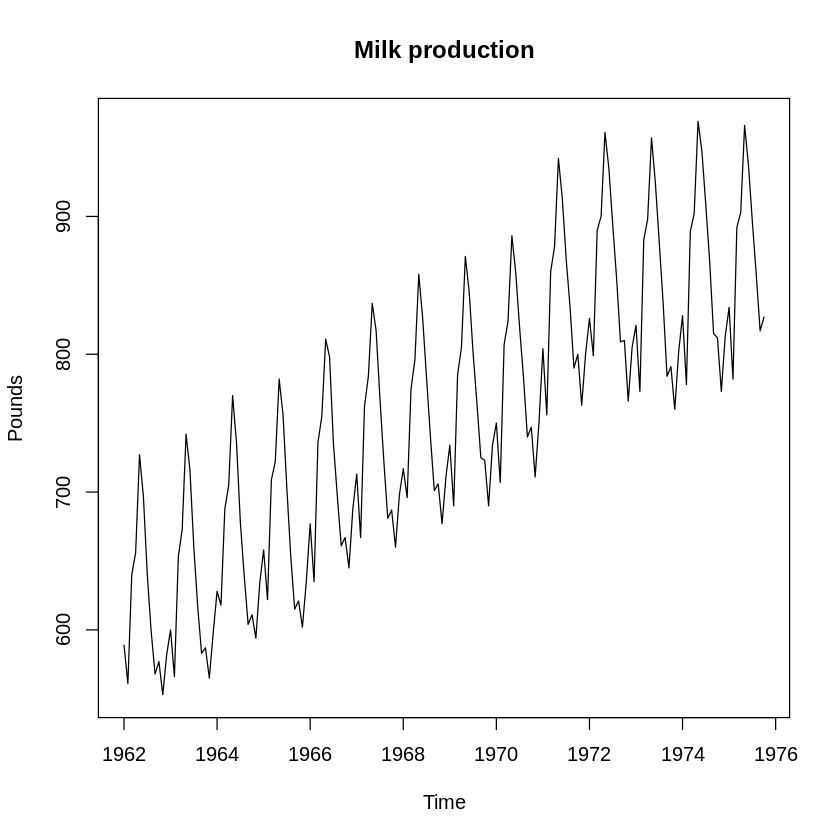

In [40]:
values = data[2]
values = ts(values, start=c(1962, 1), end=c(1975, 10), frequency=12)
ts.plot(values, main="Milk production", ylab="Pounds")

In [13]:
summary(values)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  553.0   677.2   758.0   753.9   823.2   969.0 

In [14]:
end(values)

[1] 1975   10

In [15]:
# Remove first and last columns and then transpose the data set and then converted to a vector 
temp = as.vector(t(data[,-c(1, 3)]))

In [16]:
head(temp)

[1] 589 561 640 656 727 697

In [54]:
summary(temp)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  553.0   677.8   761.0   754.7   824.5   969.0 

In [57]:
#convert it to time series ts object with starting year 1879 and frequency 12 month
temp = ts(temp,start=1962,frequency=12)

In [58]:
#print the top 10 values
head(temp,10)
#temp

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct
1962,589,561,640,656,727,697,640,599,568,577


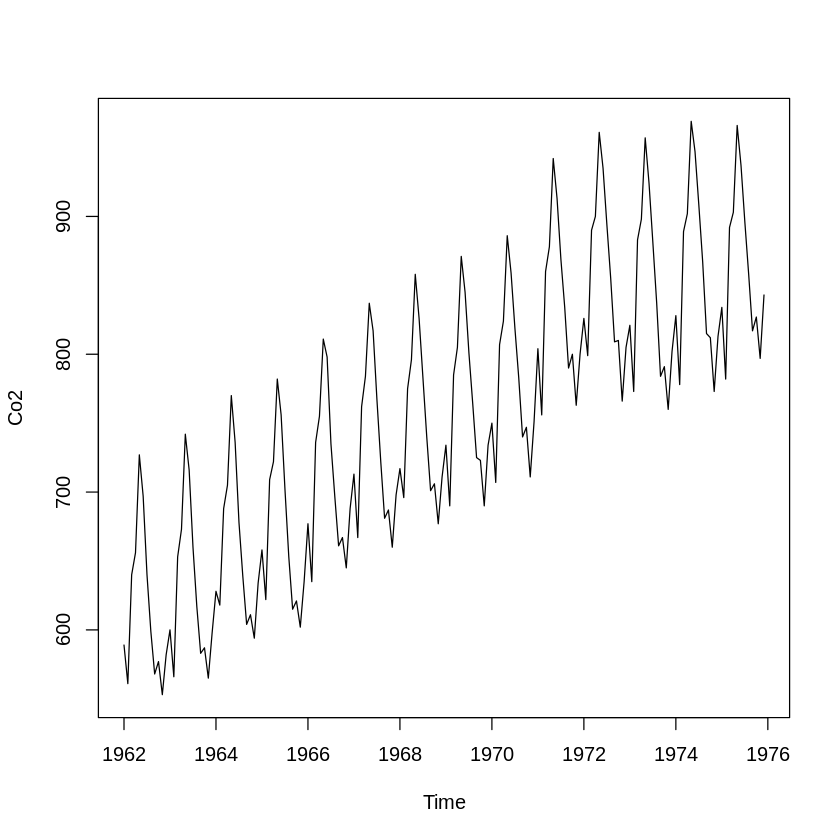

In [59]:
ts.plot(temp,ylab="Co2")

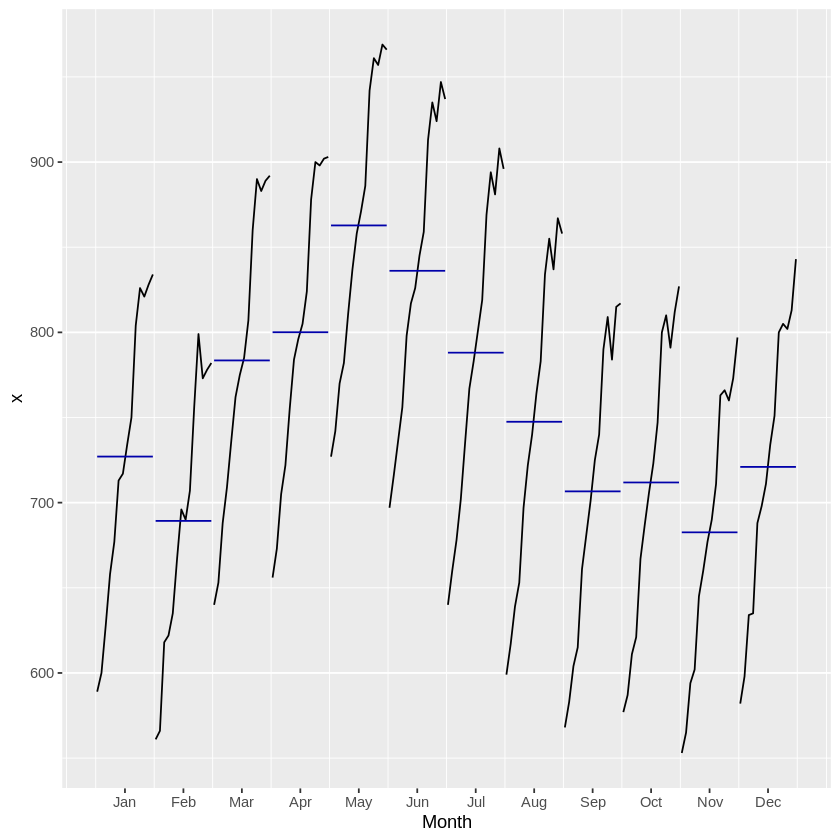

In [60]:
ggmonthplot(temp)

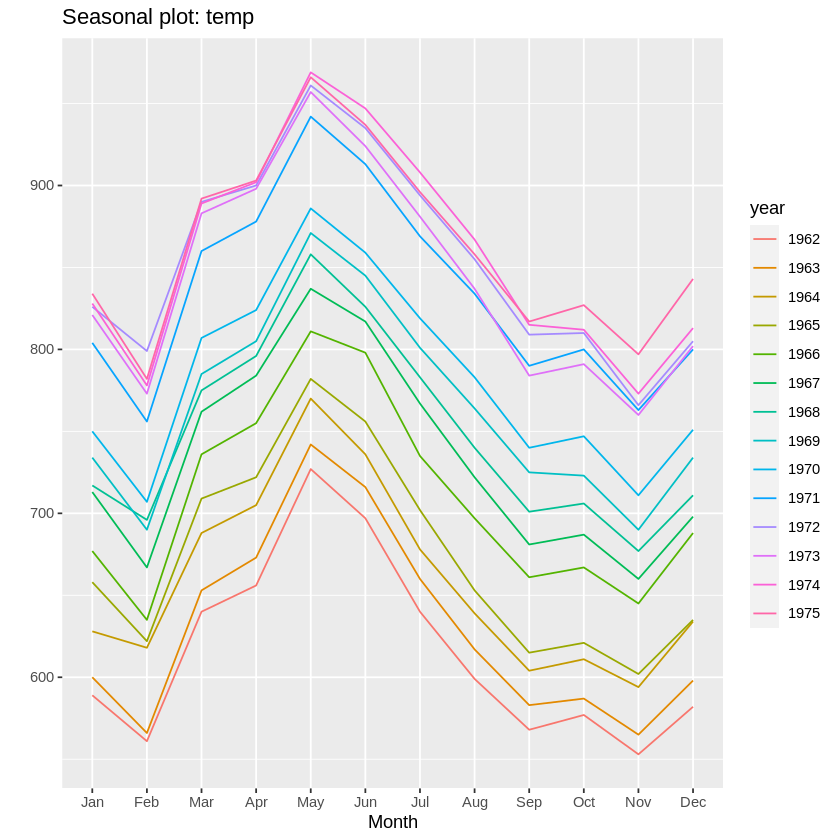

In [61]:
ggseasonplot(temp)

So there is a strong correlation between the values one year apart, meaning this cycles are actually seasonality

## Smoothing the data

We can use smoothing to reduce the volatility in our observed data and making it into a more stable and
predictable series

### Trend Analysis - non-parametric

In [20]:
time.pts = c(1:length(values))
time.pts = c(time.pts - min(time.pts))/max(time.pts)

Fitting a moving average, kernel smoothing, loess and splines smoothing

In [112]:
#define mav/smoothing methods, and fit
values.mafilter.fit = filter(values, filter = rep(1/4, 4), sides = 2)
ma.fit = ma(values, order=2, centre=TRUE)
values.fit.ma = ts(ma.fit, start=c(1962, 1), frequency=12)
ksmooth.fit = ksmooth(time.pts, values, kernel = "box", bandwidth = 0.2)
values.fit.ksmooth = ts(ksmooth.fit$y,start=c(1962, 1),frequency=12)
loess.fit = loess(as.matrix(values)~time.pts, data=values, span=0.2)
values.fit.loess = ts(predict(loess.fit), start=c(1962, 1), frequency=12)
gam.fit = gam(values~s(time.pts))
values.fit.gam = ts(fitted(gam.fit),start=c(1962, 1),frequency=12)

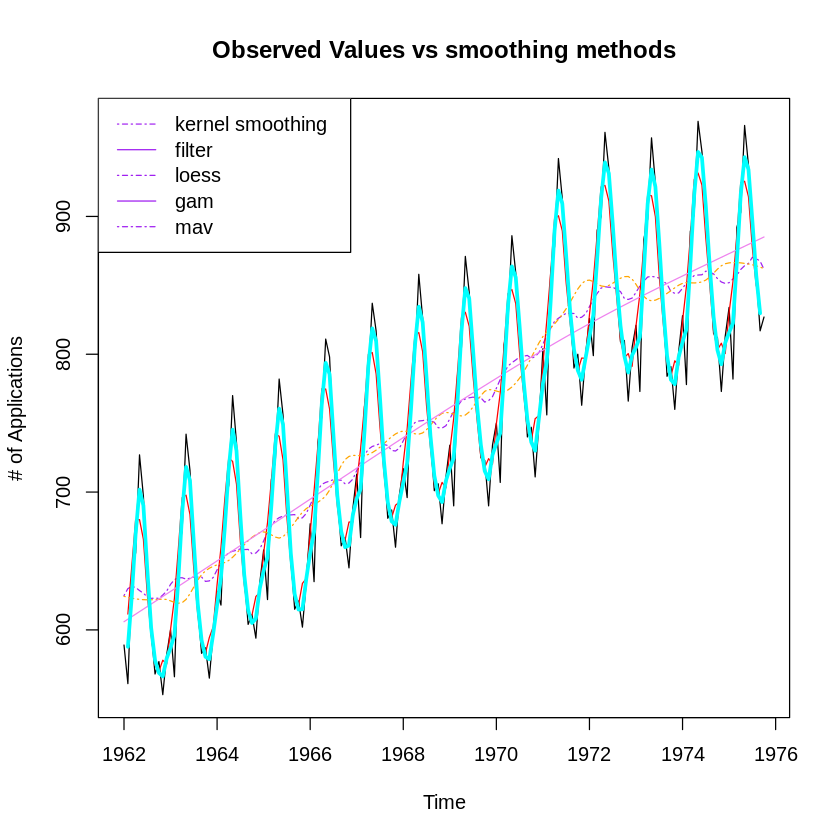

In [97]:
# plot fits against values
ts.plot(values,ylab="# of Applications", main="Observed Values vs smoothing methods")
lines(values.fit.ksmooth,lwd=1, lty=4 ,col="purple")
lines(values.mafilter.fit, col="red")
lines(values.fit.loess, col="orange", lty=4)
lines(values.fit.gam, col="violet")
lines(values.fit.ma, col="cyan", lwd=3)
legend(x="topleft",c("kernel smoothing", "filter", "loess", "gam", "mav"),lty = c(4, 1), col=c("purple"))

## Decomposing

Trend component , seasonal component and residuals (white noise). We assume this series is additive
(instead of multiplicative)

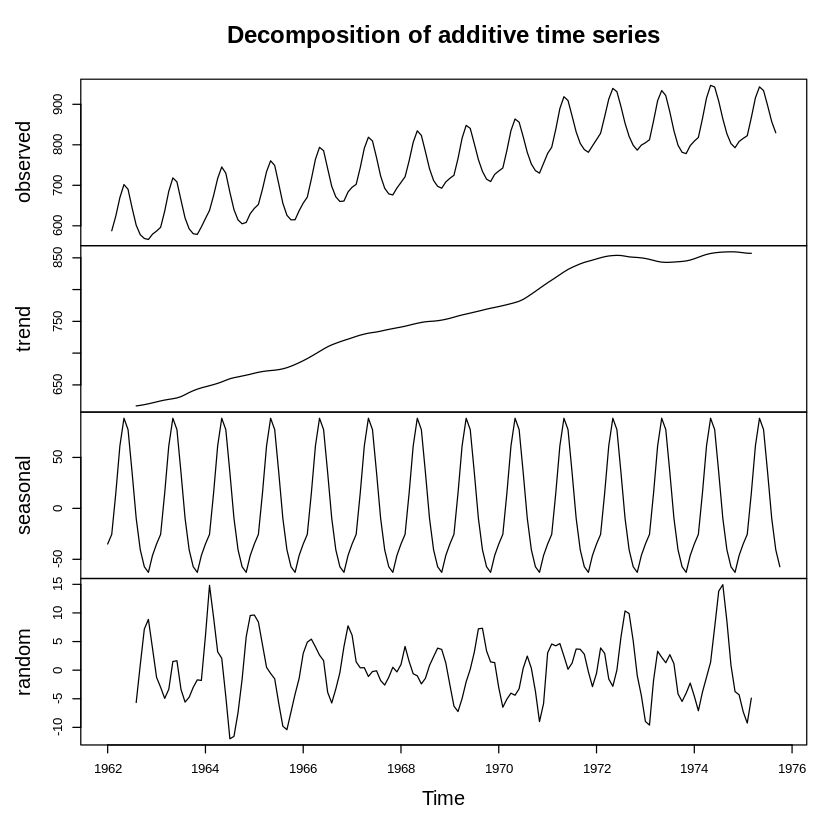

In [98]:
values.ma.decomp = decompose(values.fit.ma, type=c("additive"))
plot(values.ma.decomp)

we can see a upward trend

## Is the data stationary?

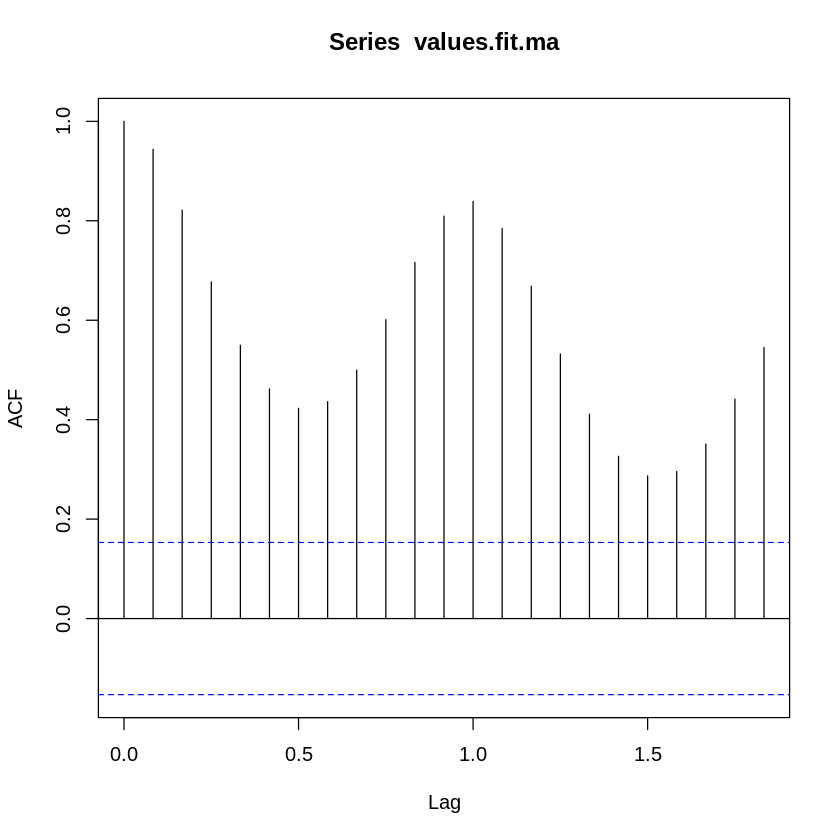

In [99]:
values.fit.ma <- ts(na.omit(values.fit.ma), frequency=12, start=c(2008, 1))
acf(values.fit.ma)


So there is a strong correlation between the values one year apart, meaning this cycles are actually seasonality

The data doesnt appear to be stationary - it is apparent that mean and variance change over time. Looking
at the ACF plot we can see a seasonal drop in the graph and it goes up. but by looking a the p- value we can see it .01 showing it is stationary so futher investagion is needed so we can use this in the ARIMA model.\
A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary). p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

Is p-value of .01 significant?
If the p-value is under . 01, results are considered statistically significant and if it's below . 005 they are considered highly statistically significant

### This data is staantionary

##  Remove heteroscedasticity

Non-constant variance - heteroscedasticity - can cause problems in linear regression. We will need to correct it before modeling to remove the increase in variance in our series. We will apply the log function to the time series. If the series is multiplicative (Yt=Seasont∗Trendt∗Et), this will also converte it to an additive time series (Yt=Seasont+Trendt+Et).

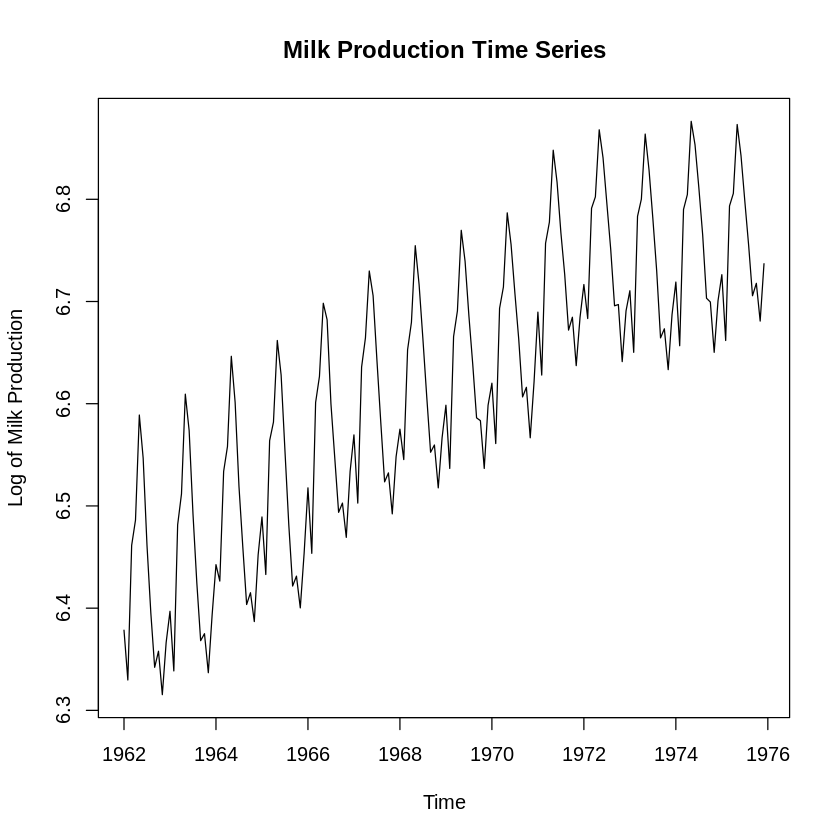

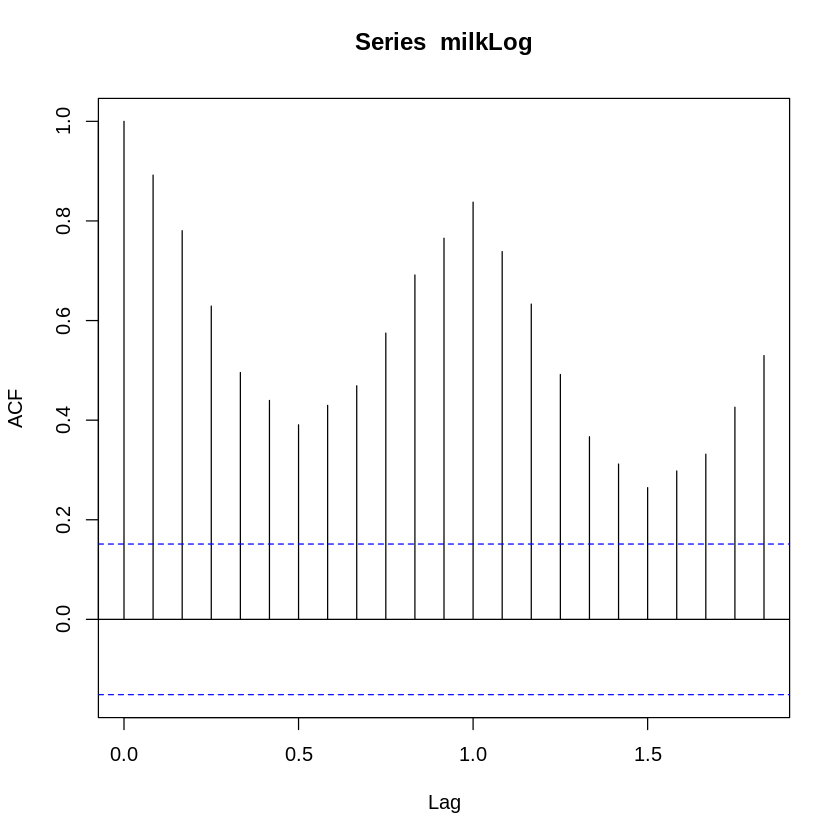

In [100]:
milkLog <- log(temp)
plot(milkLog, main='Milk Production Time Series', ylab='Log of Milk Production')
acf(milkLog)

Log serves our purpose since it did remove the increase in variance, but we could also use the more general Box-Cox transformation (of which log is a special case).

In [101]:
print(lambda <- BoxCox.lambda(temp))  # find the optimal value for parameter lambda

[1] 0.7847705


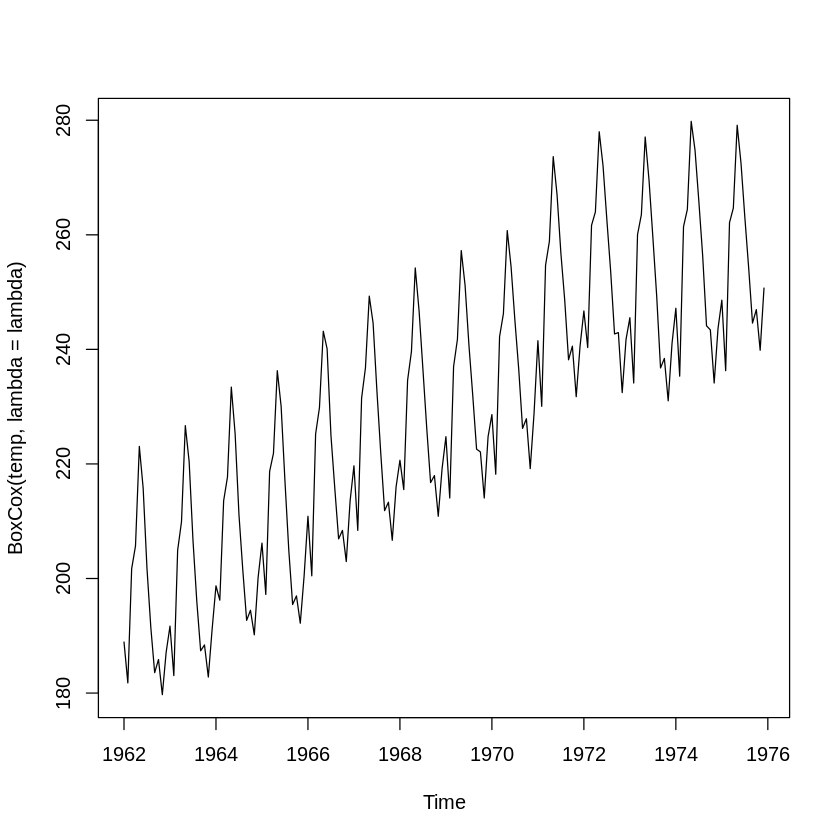

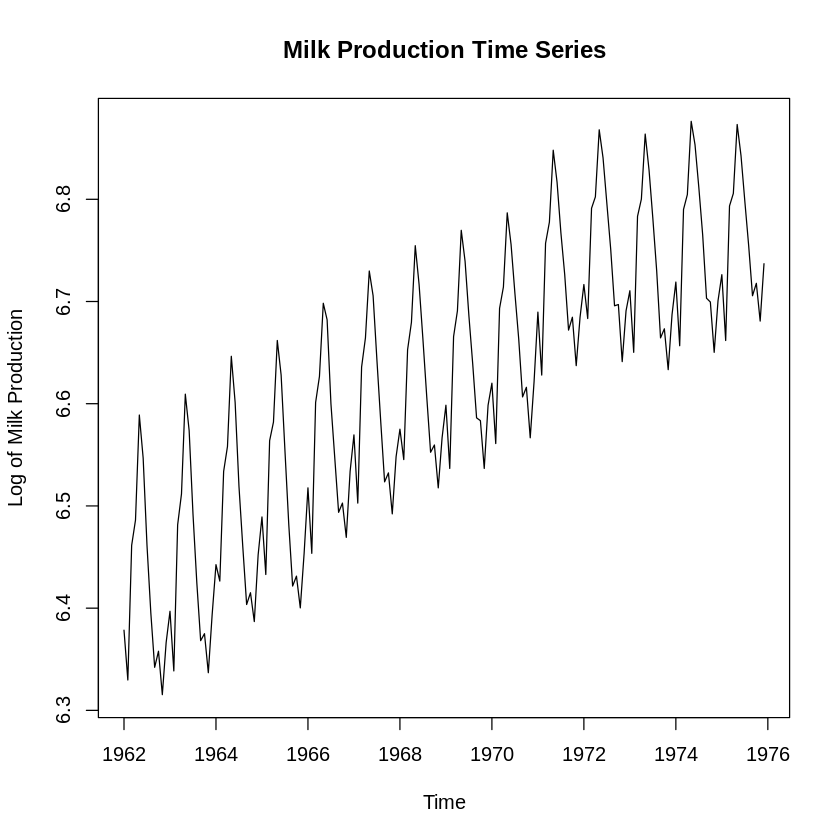

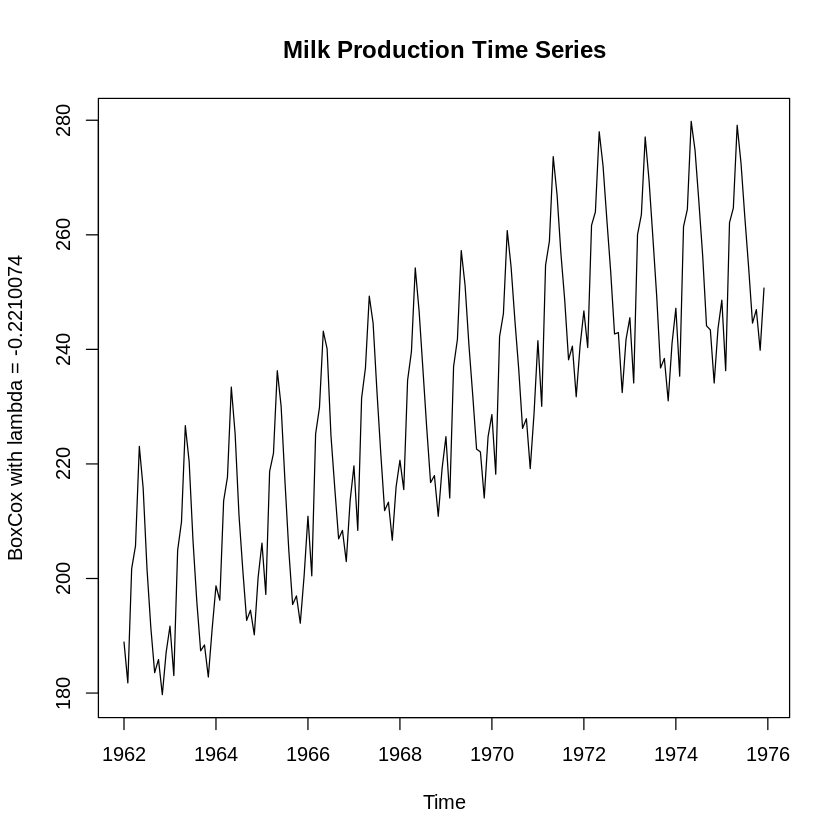

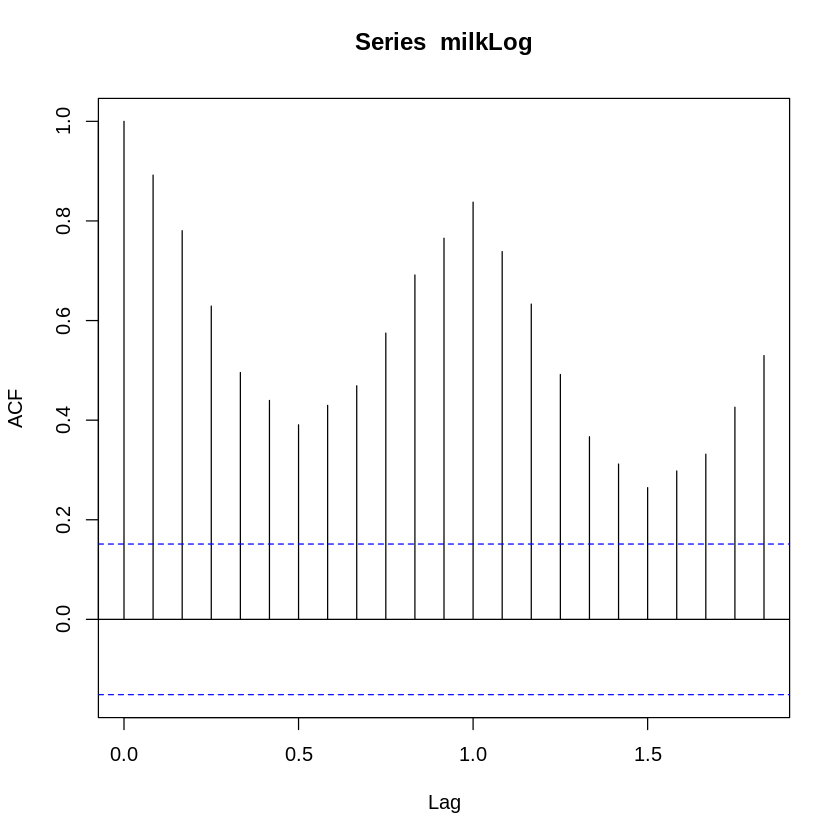

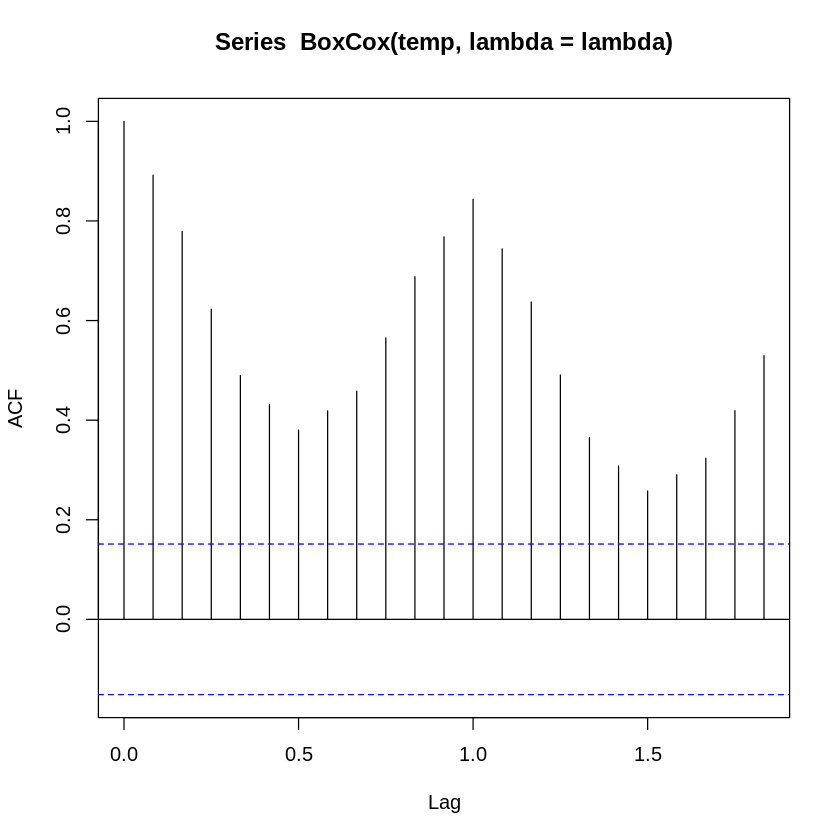

In [102]:
plot.ts(BoxCox(temp, lambda = lambda))


plot(milkLog, main='Milk Production Time Series', ylab='Log of Milk Production')
plot(BoxCox(temp, lambda = lambda), main='Milk Production Time Series', ylab='BoxCox with lambda = -0.2210074')

acf(milkLog)
acf(BoxCox(temp, lambda = lambda))

## Estimate the trend
### Using a linear model


In [103]:
summary(fit <- lm(temp~time(temp)))


Call:
lm(formula = temp ~ time(temp))

Residuals:
    Min      1Q  Median      3Q     Max 
-101.04  -50.02  -15.30   42.88  139.05 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -39237.56    2283.13  -17.19   <2e-16 ***
time(temp)      20.31       1.16   17.52   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 60.74 on 166 degrees of freedom
Multiple R-squared:  0.6489,	Adjusted R-squared:  0.6468 
F-statistic: 306.8 on 1 and 166 DF,  p-value: < 2.2e-16


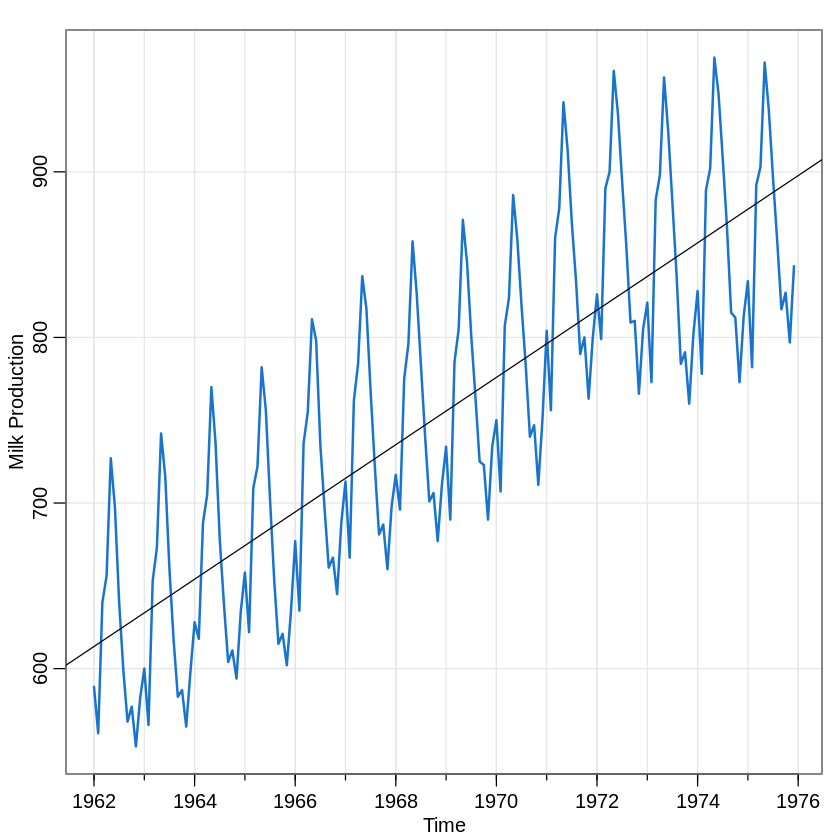

In [104]:
tsplot(temp, ylab="Milk Production", col=4, lwd=2)
abline(fit) 

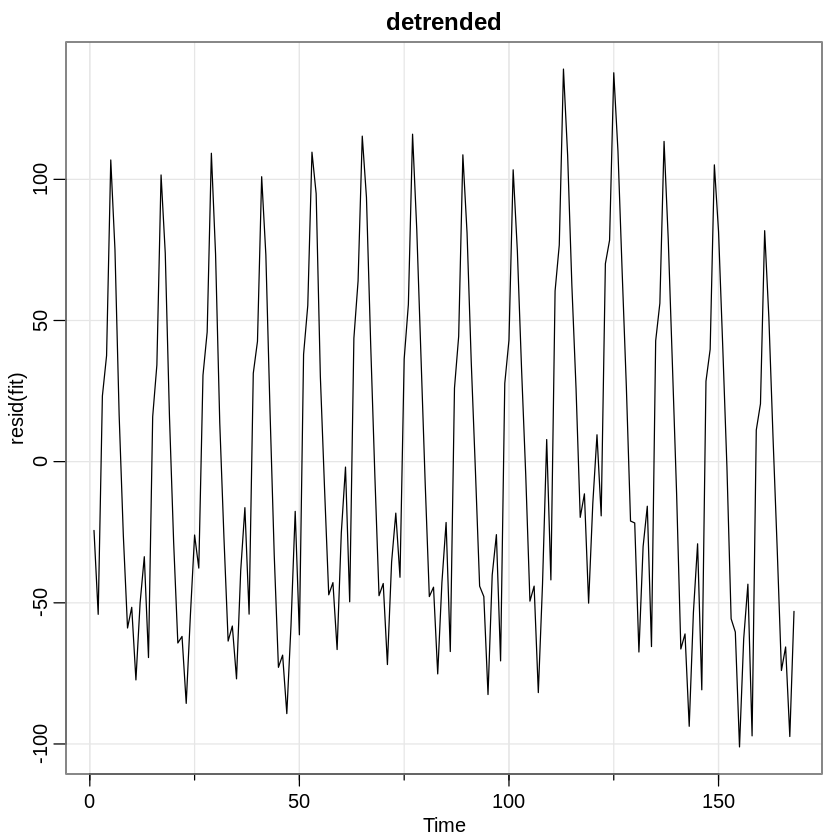

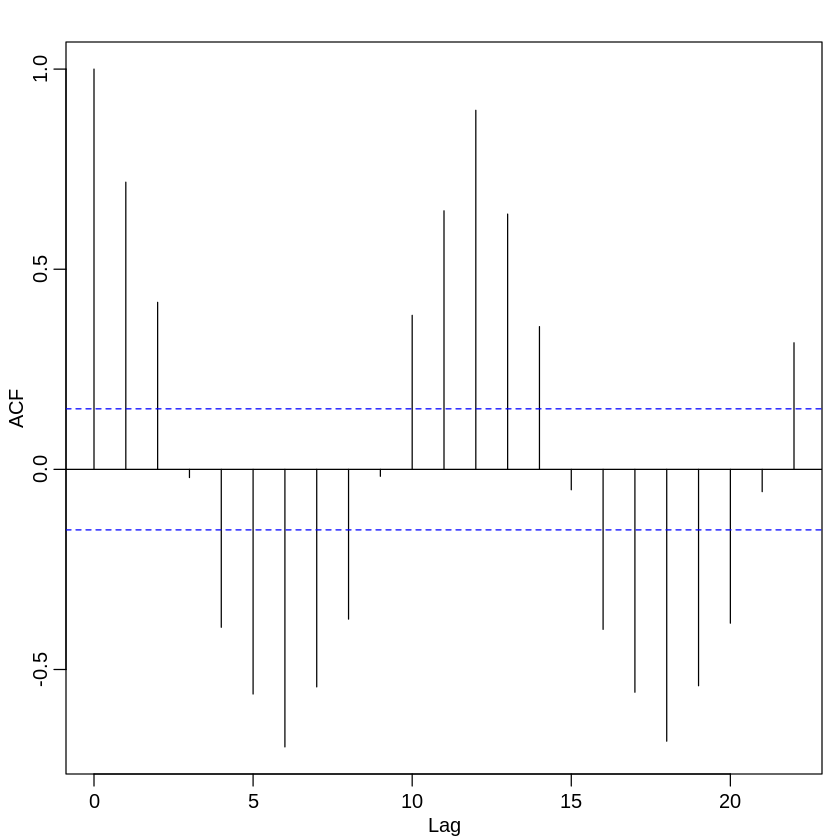

In [105]:
tsplot(resid(fit), main="detrended")
acf(resid(fit))

correlation decays with time, the ACF of the detrended series looks cyclic. We can see that lag 12 shows great correlation, lag 6 and 18 shows the minimum correlation of the first and second years, respectively. This means there must be seasonality, as said before.

## SARIMA MODEL

In [113]:
values.fit.sarima1 <- arima(values.fit.ma, order=c(1, 1, 0), seasonal = list(order = c(1, 1, 0), period = 12))
values.fit.sarima1


Call:
arima(x = values.fit.ma, order = c(1, 1, 0), seasonal = list(order = c(1, 1, 
    0), period = 12))

Coefficients:
         ar1     sar1
      0.6044  -0.4958
s.e.  0.0659   0.0735

sigma^2 estimated as 10.06:  log likelihood = -390.51,  aic = 787.02

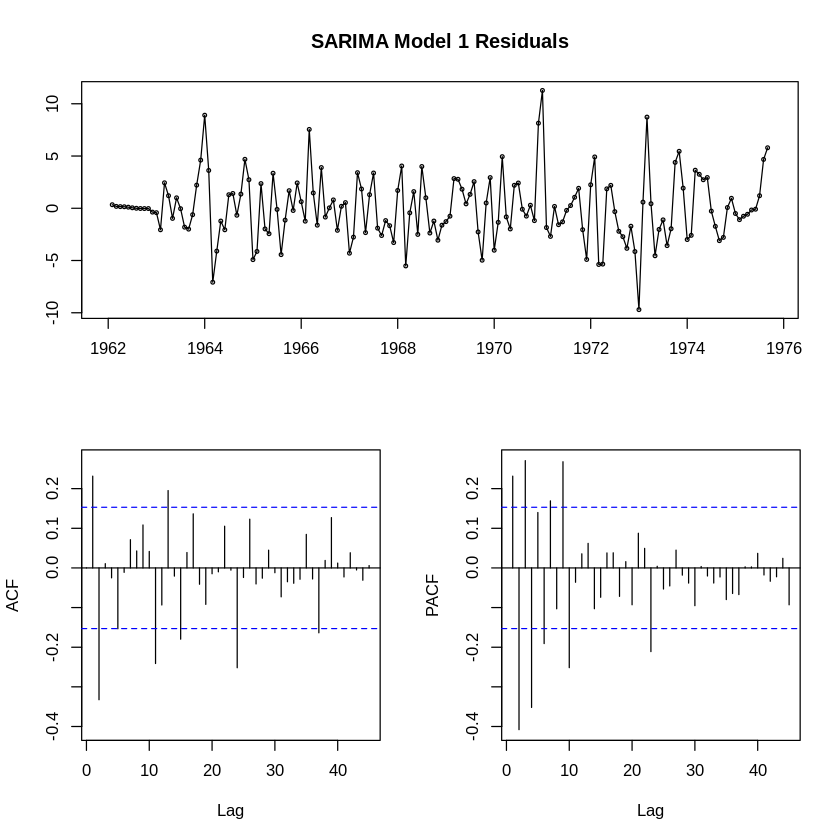

In [114]:
tsdisplay(residuals(values.fit.sarima1), lag.max=45, main='SARIMA Model 1 Residuals')

In [115]:
forecast.sarima1 <- forecast(values.fit.sarima1, h=12) #12months
accuracy(forecast.sarima1)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,0.02892712,3.048906,2.281351,0.004454627,0.3033512,0.1078167,0.2315044


In [116]:
values.fit.sarima2 <- arima(values.fit.ma, order=c(3, 1, 0), seasonal = list(order = c(1, 1, 0), period = 12))
values.fit.sarima2


Call:
arima(x = values.fit.ma, order = c(3, 1, 0), seasonal = list(order = c(1, 1, 
    0), period = 12))

Coefficients:
         ar1      ar2     ar3     sar1
      0.9451  -0.6312  0.3053  -0.4929
s.e.  0.0781   0.0963  0.0785   0.0734

sigma^2 estimated as 7.812:  log likelihood = -371.66,  aic = 753.32

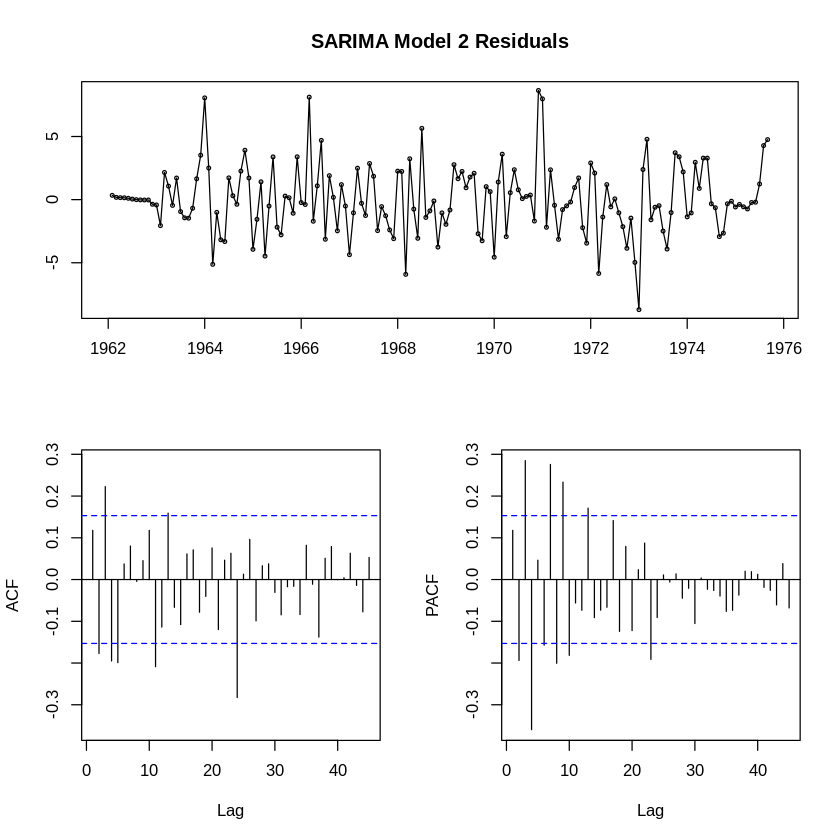

In [117]:
tsdisplay(residuals(values.fit.sarima2), lag.max=45, main='SARIMA Model 2 Residuals')

Let’s keep this model and check for other types of models

## Holt Winters

Trying a different model, exponential smoothing

Warning message in ets(values.fit.ma, model = "MAM", damped = FALSE):
“Missing values encountered. Using longest contiguous portion of time series”


ETS(M,A,M) 

Call:
 ets(y = values.fit.ma, model = "MAM", damped = FALSE) 

  Smoothing parameters:
    alpha = 0.4996 
    beta  = 0.0053 
    gamma = 0.5003 

  Initial states:
    l = 611.5301 
    b = 0.7895 
    s = 0.9526 0.9298 0.9014 0.9055 0.9211 0.9716
           1.0493 1.1317 1.1436 1.0968 1.0242 0.9723

  sigma:  0.0086

     AIC     AICc      BIC 
1463.081 1467.273 1515.779 

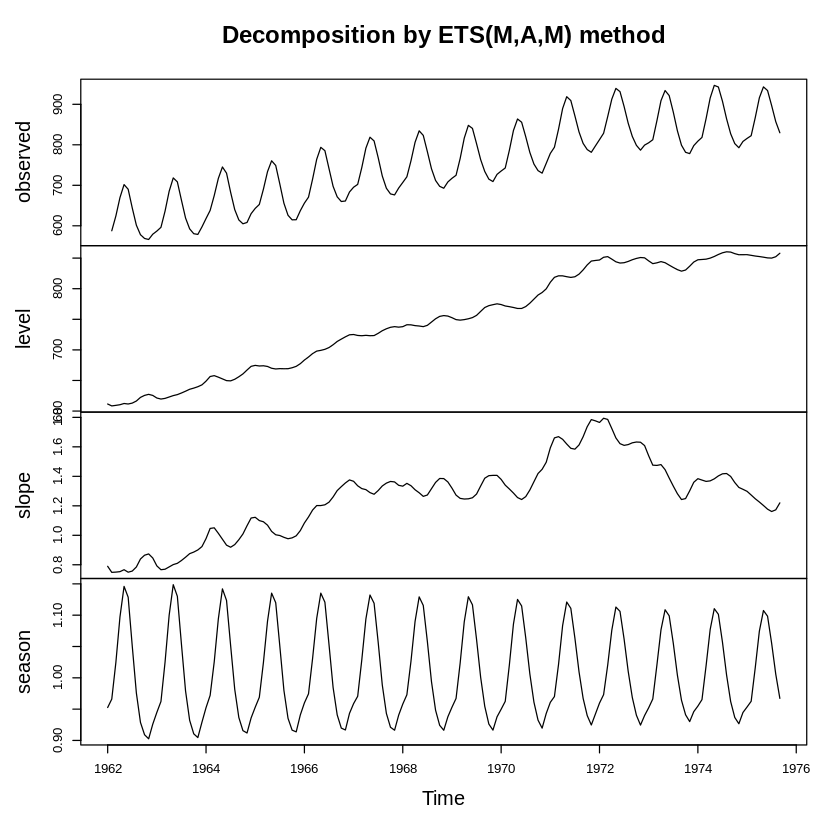

In [118]:
values.fit.hw1 <- ets(values.fit.ma, model="MAM", damped=FALSE)
values.fit.hw1
plot(values.fit.hw1)

In [111]:
accuracy(values.fit.hw1)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,0.3241622,6.048627,4.945295,0.07620602,0.6637119,0.2337147,0.730817


## Model evaluation and forecasting

I cannot find any thhing in 1976 in milk production
### Model evaluation and forecasting

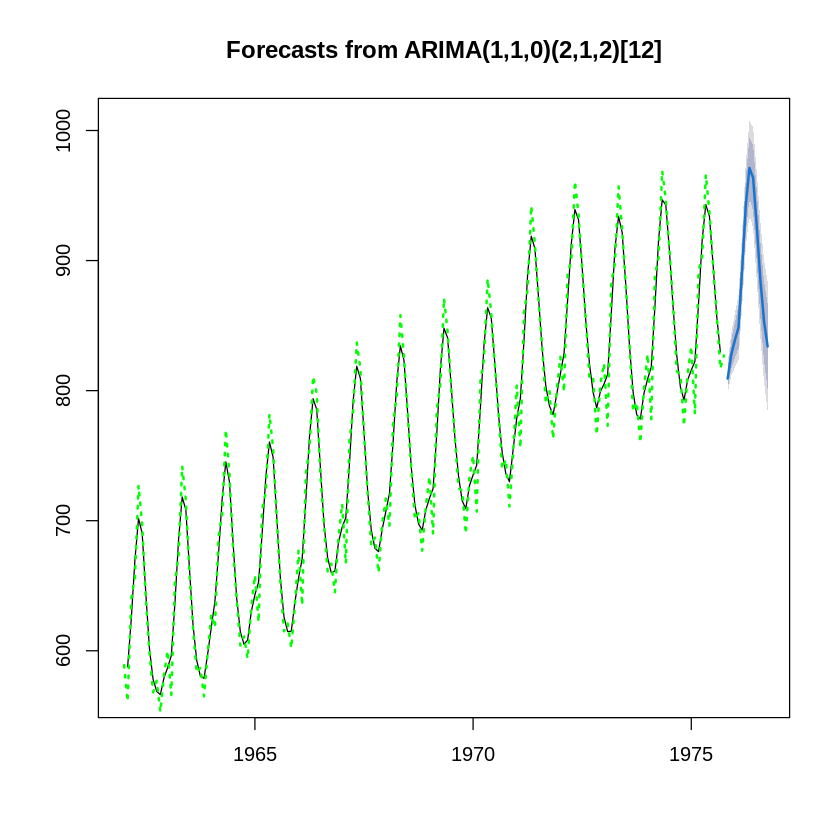

In [121]:
forecast.values.sarima3 <- forecast(values.fit.sarima3, h=12)
plot(forecast.values.sarima3)
lines(values, col="green", lwd=2, lty=3)


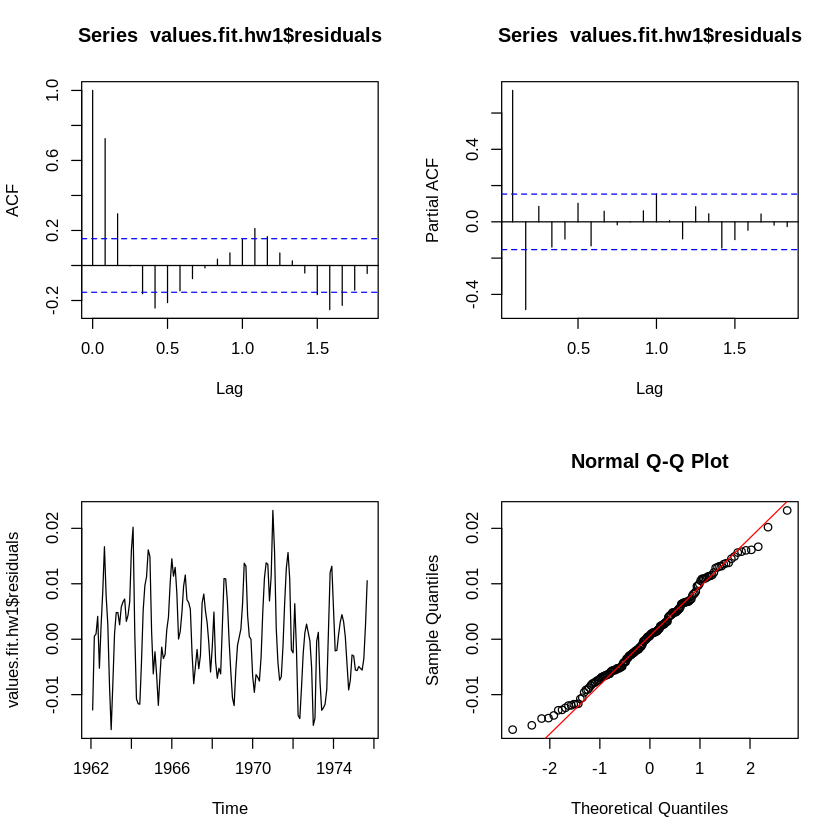

In [123]:
par(mfrow=c(2,2))
acf(values.fit.hw1$residuals)
pacf(values.fit.hw1$residuals)
plot(values.fit.hw1$residuals)
qqnorm(values.fit.hw1$residuals)
qqline(values.fit.hw1$residuals, col="red")

## Conclusions

My conclusion of this data 'Milk production 1962-1975 is that its a stationary with a cycle treand as we can in the following graphs there is a jump of milk production in may of every year with also a downfall afterwards and by forecasrt I you were able to see a dayward trend as there is every year showing there a cycle here second dairy reseach can be done to explain why is that.
Also we cam see a upward trend in milk production most likey cause of growing population.